# Маркетинговая аналитика Яндекс.Афиши

Мы попали на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Наш проект — это первое задание стажировки. Мы должны помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

У нас есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Нам предстоит изучить:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Выручка измеряется в условных единицах — у.е.

## Содержание<a name='Содержание'></a>

1. [Изучение и подготовка данных](#1.-Изучение-и-подготовка-данных)
	1. [Знакомство](#Знакомство)
	2. [Подготовка данных](#Подготовка-данных)
2. [Расчет метрик и построение графиков](#2.-Расчет-метрик-и-построение-графиков)
	1. [Продуктовые метрики](#Продуктовые-метрики)
        1. [DAU, WAU, MAU](#DAU,-WAU,-MAU)
        2. [Среднее количество сессий в день на пользователя](#Среднее-количество-сессий-в-день-на-пользователя)
        3. [Cколько времени пользователи проводят на сайте](#Cколько-времени-пользователи-проводят-на-сайте)
        4. [Retention Rate](#Retention-Rate)
	2. [Метрики электронной коммерции](#Метрики-электронной-коммерции)
        1. [Среднее время между первым визитом и покупкой](#Среднее-время-между-первым-визитом-и-покупкой)
        2. [Среднее количество покупок на одного покупателя за полгода](#Среднее-количество-покупок-на-одного-покупателя-за-полгода)
        3. [Средний чек](#Средний-чек)
        4. [Изменение во времени LTV на покупателя по когортам](#Изменение-во-времени-LTV-на-покупателя-по-когортам)
	3. [Маркетинговые метрики](#Маркетинговые-метрики)
        1. [Общая сумма расходов на маркетинг и распределение трат по источникам](#Общая-сумма-расходов-на-маркетинг-и-распределение-трат-по-источникам)
        2. [Cредний CAC всего проекта и каждого источника трафика](#Cредний-CAC-всего-проекта-и-каждого-источника-трафика)
        3. [ROMI по когортам в разрезе источников](#ROMI-по-когортам-в-разрезе-источников)
3. [Общий вывод](#3.-Общий-вывод)
	1. [Приоритетные источники трафика](#Приоритетные-источники-трафика)
	2. [Выводы после подсчета метрик](#Выводы-после-подсчета-метрик)
	3. [Итоги когортного анализа](#Итоги-когортного-анализа)

## 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Изучение и подготовка данных<a name="1.-Изучение-и-подготовка-данных"></a>

### Знакомство<a name="Знакомство"></a>

Сохраним данные о визитах, заказах и рекламных расходах в переменные `visits`, `orders` и `costs` соответственно.

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

Посмотрим на общую информацию о датафреймах.

In [3]:
def show_stats(df, title=''):
    print('\033[1m' + title + '\033[0m')
    display(df)
    print(df.info())
    print(df.describe())

#### Посещения

Каждый объект в `visits` — это информация о посещении сайта одним пользователем. Известно:
* Device — тип устройства, которым пользовался посетитель;
* End Ts — дата и время, оконачания сессии;
* Source Id — идентификатор источника, из которого пришел пользователь;
* Start Ts — дата и время начала сессии;
* Uid — идентификатор пользователя.

In [4]:
show_stats(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
           Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19


#### Заказы

В `orders` хранятся данные о заказах покупателей. Каждая строчка содержит:
* Buy Ts — дата и время покупки,
* Revenue — сумма покупки,
* Uid — идентификатор пользователя.

In [5]:
show_stats(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
            Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19


#### Рекламные расходы

`costs` содержит сведения о рекламных расходах. А именно:
* source_id — идентификатор источника, на который потратили бюджет,
* dt — дата оплаты,
* costs — сумма расходов.

In [6]:
show_stats(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
         source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000


#### Вывод

Какие проблемы мы нашли после знакомства с данными:
* в датафреймах `visits` и `orders` «неудобные» названия столбцов. Приведем их к нижнему регистру и заменим пробелы на нижние подчеркивания.
* во всех таблицах неверный тип у дат: должен быть `datetime`, а на деле `object`. Заменим их на правильные.
* понизим размерности у всех численных столбцов, кроме `Uid`, для уменьшения использованной памяти.

[К содержанию](#Содержание)

### Подготовка данных<a name="Подготовка-данных"></a>
#### Переименование столбцов

Переименуем столбцы и посмотрим на шапки таблиц.

In [7]:
visits = visits.rename(columns={
    'Device': 'device',
    'End Ts': 'end_ts',
    'Source Id': 'source_id',
    'Start Ts': 'start_ts',
    'Uid': 'uid'
})

orders = orders.rename(columns={
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue',
    'Uid': 'uid'
})

print('Название столбцов в датафрейме visits:')
display(visits.head(0))

print('Название столбцов в датафрейме orders:')
orders.head(0)

Название столбцов в датафрейме visits:


,device,end_ts,source_id,start_ts,uid


Название столбцов в датафрейме orders:


,buy_ts,revenue,uid


Теперь мы не будем путаться с регистрами и пробелами.

#### Замена типа данных

Сначала исправим все столбцы с датами. Для этого воспользуемся методом `to_datetime` из `pandas`.

In [8]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

costs['dt'] = pd.to_datetime(costs['dt'])

Теперь понизим размерность численных столбцов с помощью метода `to_numeric` с параметром `downcast`. Так у численных столбцов будут минимальные размерности с учетом их содержимого.

In [9]:
visits['source_id'] = pd.to_numeric(visits['source_id'], downcast='unsigned')
visits['uid'] = pd.to_numeric(visits['uid'], downcast='unsigned')

orders['revenue'] = pd.to_numeric(orders['revenue'], downcast='float')
orders['uid'] = pd.to_numeric(orders['uid'], downcast='unsigned')

costs['source_id'] = pd.to_numeric(costs['source_id'], downcast='unsigned')
costs['costs'] = pd.to_numeric(costs['costs'], downcast='float')

Еще раз посмотрим на общую информацию о датафреймах, чтобы проверить, что типы у столбцов изменились на нужные.

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  uint8         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), object(1), uint64(1), uint8(1)
memory usage: 11.3+ MB


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float32       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.8 KB


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   uint8         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float32       
dtypes: datetime64[ns](1), float32(1), uint8(1)
memory usage: 32.4 KB


Все получилось, как мы хотели: столбцы с датами стали `datetime`, а у колонок с числами понизилась размерность.

#### Поиск дубликатов

Последний этап подготовки данных — проверка наличия дубликатов. Нам повезло: в датафреймах нет строковых переменных c большим количеством вариантов значений, поэтому нам не надо обрабатывать их перед проверкой. В столбце `device` таблицы `visits` всего два уникальных значения: desktop и touch.

Применим к таблицам метод `duplicated()`, который каждой повторяющейся строке, кроме первого экземпляра, ставит True. Подсчитаем количество таких True методом `sum()`.

In [13]:
visits.duplicated().sum()

0

In [14]:
orders.duplicated().sum()

0

In [15]:
costs.duplicated().sum()

0

В датафреймах нет дубликатов, ура!

#### Вывод

Мы познакомились с данными и исправили несколько проблем в них:
* поменяли названия столбцов на более удобные,
* заменили типы данных: даты вместо `object` стали `datetime`, а у чисел уменьшилась размерность, из-за чего таблицы стали меньше весить;
* проверили, что в датафреймых нет дубликатов.

[К содержанию](#Содержание)

## 2. Расчет метрик и построение графиков<a name="2.-Расчет-метрик-и-построение-графиков"></a>

### Продуктовые метрики<a name="Продуктовые-метрики"></a>

#### DAU, WAU, MAU<a name="DAU,-WAU,-MAU"></a>

Чтобы расчитать DAU, WAU и MAU, добавим в `visits` вспомогательные столбцы с датой, неделей и месяцем визита. Идентификатором недели и месяца будут первые числа этих периодов. Посмотрим на них.

In [16]:
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01


Создадим датафреймы с DAU, WAU и MAU. Для этого сгруппируем визиты по временным периодам и посчитаем количество уникальных посетителей за эти промежутки.

In [17]:
daus = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()
daus.columns = ['date', 'n_users']

daus.head()

,date,n_users
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [18]:
waus = visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index()
waus['session_week'] = pd.to_datetime(waus['session_week']).dt.to_period('W')
waus.columns = ['week', 'n_users']

waus.head()

,week,n_users
0,2017-05-29/2017-06-04,4082
1,2017-06-05/2017-06-11,3311
2,2017-06-12/2017-06-18,2844
3,2017-06-19/2017-06-25,3079
4,2017-06-26/2017-07-02,3055


In [19]:
maus = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()
maus['session_month'] = pd.to_datetime(maus['session_month']).dt.to_period('M')
maus.columns = ['month', 'n_users']

maus.head()

,month,n_users
0,2017-06,13259
1,2017-07,14183
2,2017-08,11631
3,2017-09,18975
4,2017-10,29692


Теперь построим распределения DAU, WAU и MAU по соответствующим временным периодам. 

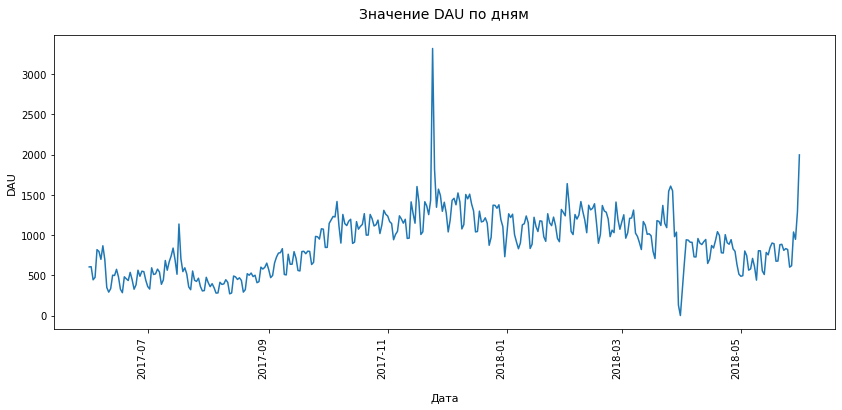

In [20]:
daus.plot(x='date', y='n_users', kind='line', legend=False, figsize=(14, 6))
plt.title('Значение DAU по дням', fontsize=14, y=1.04)
plt.xlabel('Дата', fontsize=11, labelpad=15)
plt.xticks(rotation='vertical')
plt.ylabel('DAU', fontsize=11)

dau_graph = plt.gcf()

На распределении DAU виден пик в конце ноября. Скорее всего, это «Черная пятница» — большая распродажа, которую устраивают офлайн- и онлайн-магазины, чтобы подсветить начало скидок перед Новым годом.

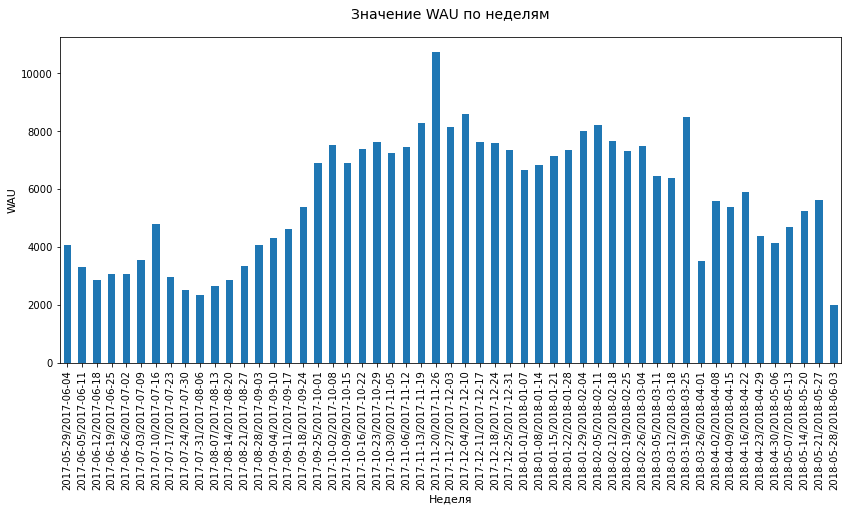

In [21]:
waus.plot(x='week', y='n_users', kind='bar', legend=False, figsize=(14, 6))
plt.title('Значение WAU по неделям', fontsize=14, y=1.04)
plt.xlabel('Неделя', fontsize=11)
plt.ylabel('WAU', fontsize=11)

wau_graph = plt.gcf()

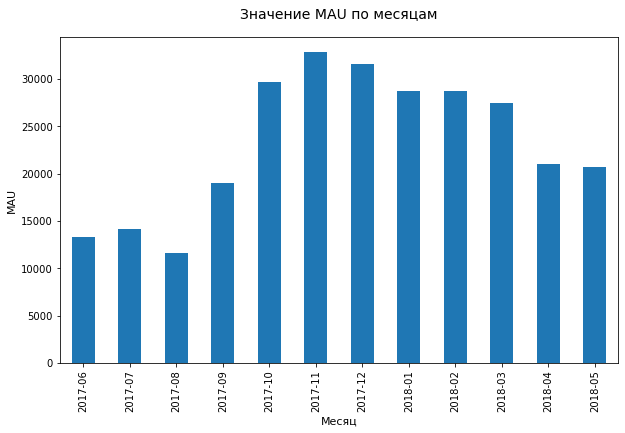

In [22]:
maus.plot(x='month', y='n_users', kind='bar', legend=False, figsize=(10, 6))
plt.title('Значение MAU по месяцам', fontsize=14, y=1.04)
plt.xlabel('Месяц', fontsize=11)
plt.ylabel('MAU', fontsize=11)

mau_graph = plt.gcf()

Распределения WAU и MAU показывают, что посещаемость Яндекс.Афиши с октября по март больше, чем в другие месяцы. Это классическая сезонность для ивент-индустрии. В холодное время года люди чаще ходят на мероприятия из-за плохой погоды, а летом многие предпочитают прогулки на свежем воздухе. Также лето — сезон отпусков, когда клиенты путешествуют. Это тоже уменьшает спрос на мероприятия.

Вычислим средние значения DAU, MAU и WAU за весь период и выведем их.

In [23]:
dau_mean = daus['n_users'].mean()
wau_mean = waus['n_users'].mean()
mau_mean = maus['n_users'].mean()

print('Средние DAU, WAU, MAU за весь период')
print('DAU:', round(dau_mean))
print('WAU:', round(wau_mean))
print('MAU:', round(mau_mean))

Средние DAU, WAU, MAU за весь период
DAU: 908
WAU: 5724
MAU: 23228


#### Среднее количество сессий в день на пользователя<a name="Среднее-количество-сессий-в-день-на-пользователя"></a>

Чтобы посчитать среднее количестно визитов в день на одного клиента, найдем число визитов и уникальных пользователей для каждого дня. Разделим первое число на второе и получим количество визитов на одного пользователя за каждый день. Построим распределение этой величины по времени.

In [24]:
visits_per_user = visits.groupby('session_date').agg({'uid': ['count', 'nunique']}).reset_index()
visits_per_user.columns = ['date', 'n_visits', 'n_users']

visits_per_user['visits_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']

visits_per_user.head()

,date,n_visits,n_users,visits_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


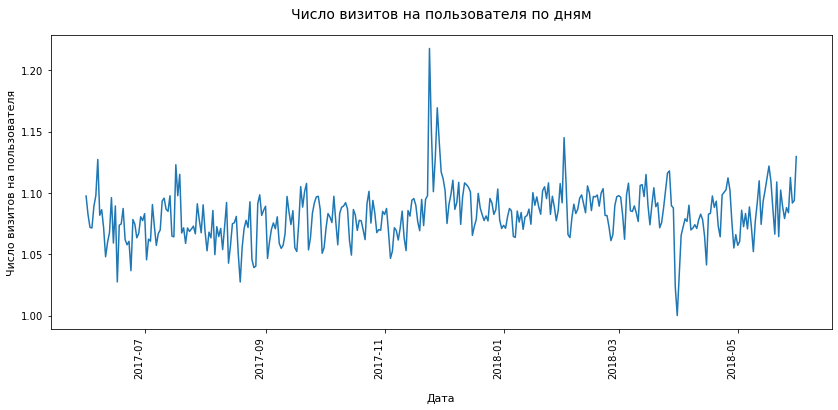

In [25]:
visits_per_user.plot(x='date', y='visits_per_user', kind='line', legend=False, figsize=(14, 6))
plt.title('Число визитов на пользователя по дням', fontsize=14, y=1.04)
plt.xlabel('Дата', fontsize=11, labelpad=15)
plt.xticks(rotation='vertical')
plt.ylabel('Число визитов на пользователя', fontsize=11)

visits_per_user_graph = plt.gcf()

Теперь найдем среднее число посещений в день. Для этого сначала суммируем число посещений и число уникальных пользователей по дням, а затем разделим первое значение на второе.

In [26]:
mean_visits_per_day_per_user = visits_per_user['n_visits'].sum() / visits_per_user['n_users'].sum()

print('Среднее число посещений в день на одного пользователя: {:.2f}'.format(mean_visits_per_day_per_user))

Среднее число посещений в день на одного пользователя: 1.09


В среднем клиенты заходят на Яндекс.Афишу один раз в день.

#### Cколько времени пользователи проводят на сайте<a name="Cколько-времени-пользователи-проводят-на-сайте"></a>

Вычислим продолжительность каждой сессии и посмотрим на распределение значений, чтобы выбрать подходящую среднюю меру.

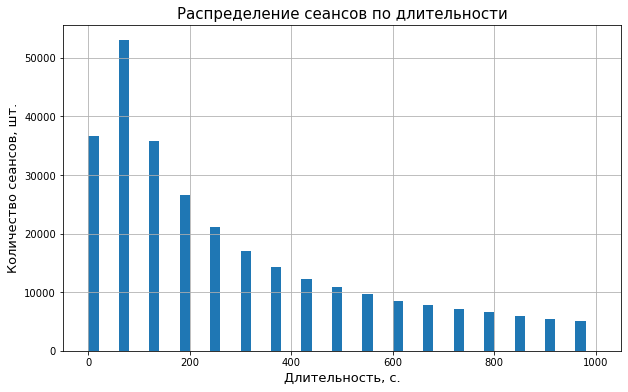

In [27]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['session_duration_sec'].hist(bins=50, range=(0, 1000), figsize=(10, 6))
plt.title('Распределение сеансов по длительности', fontsize=15)
plt.xlabel('Длительность, с.', fontsize=13)
plt.ylabel('Количество сеансов, шт.', fontsize=13)

duration_graph = plt.gcf()

Видно, что распределение скошено вправо. Поэтому как меру типичной пользовательской сессии выберем медиану. Большие значения могли получиться из-за забатых открытых вкладок.

In [28]:
average_session_length = visits['session_duration_sec'].median()
print(average_session_length)

300.0


Продолжительность типичной пользовательской сессии составляет 5 минут. 

#### Retention Rate<a name="Retention-Rate"></a>

Чтобы расчитать коэффициент удержания, поделим пользователей на когорты. В качестве события возьмем первое посещение сайта, а в качестве периода — месяц.

Создадим таблицу `first_visit_date` с двумя столбцами: идентификатор пользователя и время первого визита. Посмотрим на ее первые строки.

In [29]:
first_visit_date = visits.sort_values('start_ts').groupby('uid').first().reset_index()
first_visit_date = first_visit_date[['uid', 'start_ts']]
first_visit_date.columns = ['uid', 'first_visit_date']
first_visit_date.head()

,uid,first_visit_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Добавим время первого визита в таблицу `visits`. Для этого объединим ее с `first_visit_date` по столбцу `uid`. Посмотрим на результат.

In [30]:
visits = pd.merge(visits, first_visit_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_duration_sec,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-09 20:05:00


Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты:
1. Добавим в `visits` месяц первого посещения.
2. Из месяца текущего визита вычтем певрый месяц посещения сайта и сохраним результат в столбец `cohort_lifetime`.
3. У столбца `cohort_lifetime` будет тип timedelta. Преобразуем этот тип в число месяцев, прошедших между датами. Для этого cohort_lifetime нужно разделить на константу np.timedelta64(1, 'M'). После этого мы получим дробное число. Округлим его и приведем к целочисленному типу. 

Посмотрим, что получилось.

In [31]:
#1
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

#2
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_visit_month'])

#3
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_duration_sec,first_visit_date,first_visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-09 20:05:00,2018-03-01,0


Сгруппируем данные по когорте (месяц первого посещения) и lifetime. Посчитаем для каждой когорты количество активных пользователей на определенный «месяц жизни»:

In [32]:
cohorts = (visits
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
)     

cohorts.head()

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти коэффициент удержания, нам не хватает числа пользователей, изначально бывших в когорте. Ведь коэффициент удержания — это отношение количества пользователей текущего месяца к размеру когорты.

Возьмем число пользователей в когорте на нулевой месяц из таблицы `cohorts`. Это и будет размер когорты. Сохраним размеры в новый датафрейм `initial_users_count`. В нем будет два столбца: когорта (то есть первый месяц посещения) `first_visit_month` и число пользователей в ней `cohort_users`.

In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count

,first_visit_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Объединим данные по когортам с исходным количеством пользователей в когорте:

In [34]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts.head()

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


Наконец, рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [35]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту.

In [36]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_pivot.index = retention_pivot.index.to_series().apply(lambda x: x.date())
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


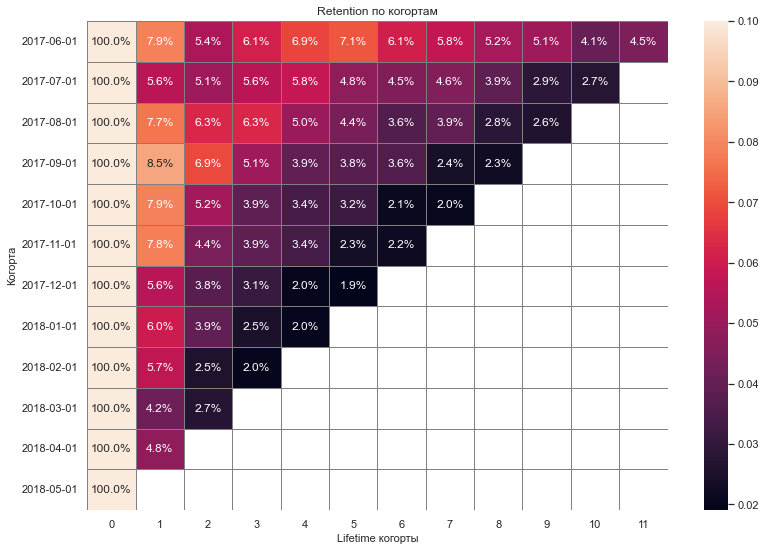

In [37]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax = 0.1)
plt.title('Retention по когортам')
plt.xlabel('Lifetime когорты', fontsize=11)
plt.ylabel('Когорта', fontsize=11)

retention_by_cohorts_graph = plt.gcf()

Retention Rate в первую неделю довольно сильно убывает в декабре. Больше чем на 2%, хотя до этого разница между месяцами была меньше процента. Скорее всего, это связано с тем, что и MAU с декабря убывает.

Найдем средний коэффициент удержания на второй месяц жизни когорт.

In [38]:
print('Cредний Retention на второй месяц «жизни» когорт: {:.1%}'.format(retention_pivot[1].mean()))

Cредний Retention на второй месяц «жизни» когорт: 6.5%


[К содержанию](#Содержание)

### Метрики электронной коммерции<a name="Метрики-электронной-коммерции"></a>

#### Среднее время между первым визитом и покупкой<a name="Среднее-время-между-первым-визитом-и-покупкой"></a>

Чтобы найти среднее время между первым визитом и покупкой, надо найти такие промежутки, а для этого нужны даты первой покупки и первого визита. Даты первых визитов у нас есть, они хранятся в таблице `first_visit_date`. Получим даты первых покупок.

In [39]:
first_order_date = orders.sort_values('buy_ts').groupby('uid').first().reset_index()
first_order_date = first_order_date[['uid', 'buy_ts']]
first_order_date.columns = ['uid', 'first_order_date']
first_order_date.head()

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Создадим новую таблицу `first_actions_dates`, которая будет объединением `first_visit_date` и `first_order_date` по идентификатору пользователей.

In [40]:
first_actions_dates = pd.merge(first_visit_date, first_order_date, on='uid')
first_actions_dates.head()

,uid,first_visit_date,first_order_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Вычтем из даты первого визита дату первой покупки. Сохраним результат в `time_between_first_visit_and_first_order` — это будет колонка с искомыми промежутками. Затем построим распределение количества таких промежутком по их длине.

In [41]:
first_actions_dates['time_between_first_visit_and_first_order'] = \
            (first_actions_dates['first_order_date'] - first_actions_dates['first_visit_date']).dt.seconds / 60

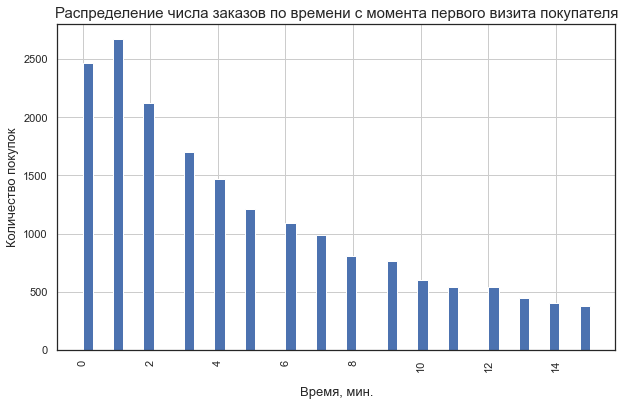

In [42]:
(first_actions_dates['time_between_first_visit_and_first_order']
 .hist(bins=50, range=(0,15), figsize=(10, 6)))

plt.title('Распределение числа заказов по времени с момента первого визита покупателя', fontsize=15)
plt.xlabel('Время, мин.', fontsize=13, labelpad=15)
plt.xticks(rotation='vertical')
plt.ylabel('Количество покупок', fontsize=13)

first_visit_to_order_graph = plt.gcf()

Большинство значений снова находится в начале распределения, поэтому мерой среднего времени между первым визитом и первой покупкой назначим медиану.

In [43]:
print('Количество минут между первым визитом и первой покупкой:',
      round(first_actions_dates['time_between_first_visit_and_first_order'].median()))

Количество минут между первым визитом и первой покупкой: 16


Как видно по гистограмме и медиане, чаще всего пользователи совершают первый заказ в день первого визита, а точнее в первые минуты.

#### Среднее количество покупок на одного покупателя за полгода<a name="Среднее-количество-покупок-на-одного-покупателя-за-полгода"></a>

Чтобы найти среднее количество заказов на одного покупателя за полгода, построим сводную таблицу, в которой строками будут когорты, столбцами — их время жизни, а значениями — накопительное число покупок на покупателя. Для этого нам нужно:

1. найти дату первой покупки каждого покупателя;
2. вычислить число новых покупателей за каждую дату;
3. добавить дату первой покупки в таблицу с заказами;
4. сгруппировать таблицу и посчитать количество покупок.

Удобнее всего сформировать месячные когорты. Выделим месяцы из даты в таблице с заказами:

In [44]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


Получим месяц первой покупки каждого покупателя: cгруппируем заказы по покупателям и найдем для каждого самую раннюю дату. Сохраним результат в таблицу `first_order_month`.

In [45]:
first_order_month = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order_month = first_order_month.rename(columns={'order_month': 'first_order_month'})
first_order_month.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Теперь мы знаем, к какой когорте относится каждый покупатель. На это указывает месяц первой покупки.

Посчитаем количество новых покупателей за каждый месяц: сгруппируем таблицу с месяцами первых заказов по месяцам и найдем, сколько уникальных пользователей попали в каждую группу.

In [46]:
orders_cohort_sizes = (
    first_order_month
    .groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
orders_cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Построим когорты:
1. добавим месяц первой покупки каждого покупателя в таблицу с заказами,
2. сгруппируем таблицу заказов по месяцу первой покупки (когортам) и месяцу каждого заказа и посчитаем количество выручек. Оно равно числу заказов.

In [47]:
#1
orders_new = pd.merge(orders, first_order_month, on='uid')

#2
orders_cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'count'})
    .reset_index()
)
orders_cohorts = orders_cohorts.rename(columns={'revenue':'n_orders'}) 

orders_cohorts.head()

,first_order_month,order_month,n_orders
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


Строка таблицы `orders_cohorts` показывает, сколько заказов сделали покупатели когорты за месяц. Объединим эту таблицу с размерами когорт и сохраним результат в новую таблицы `orders_report`.

In [48]:
orders_report = pd.merge(orders_cohort_sizes, orders_cohorts, on='first_order_month')
orders_report.head()

,first_order_month,n_buyers,order_month,n_orders
0,2017-06-01,2023,2017-06-01,2354
1,2017-06-01,2023,2017-07-01,177
2,2017-06-01,2023,2017-08-01,174
3,2017-06-01,2023,2017-09-01,226
4,2017-06-01,2023,2017-10-01,292


Найдем среднее число покупок в месяц на участника когорты. Для этого разделим количество покупок когорты в месяц на ее размер.

In [49]:
orders_report['purchases_per_user'] = orders_report['n_orders'] / orders_report['n_buyers']
orders_report.head()

,first_order_month,n_buyers,order_month,n_orders,purchases_per_user
0,2017-06-01,2023,2017-06-01,2354,1.163618
1,2017-06-01,2023,2017-07-01,177,0.087494
2,2017-06-01,2023,2017-08-01,174,0.086011
3,2017-06-01,2023,2017-09-01,226,0.111715
4,2017-06-01,2023,2017-10-01,292,0.144340


Осталось найти время жизни когорт. Для этого из месяца заказа вычтем месяц первого заказа и получим lifetime типа timedelta. Чтобы получить целое число месяцев, разделим получившиеся lifetime на длину одного месяца (np.timedelta64(1, 'M')) и округлим результат.

In [50]:
orders_report['lifetime'] = orders_report['order_month'] - orders_report['first_order_month']
orders_report['lifetime'] = (orders_report['lifetime'] / np.timedelta64(1, 'M')).round().astype('int')
orders_report.head()

,first_order_month,n_buyers,order_month,n_orders,purchases_per_user,lifetime
0,2017-06-01,2023,2017-06-01,2354,1.163618,0
1,2017-06-01,2023,2017-07-01,177,0.087494,1
2,2017-06-01,2023,2017-08-01,174,0.086011,2
3,2017-06-01,2023,2017-09-01,226,0.111715,3
4,2017-06-01,2023,2017-10-01,292,0.144340,4


Теперь в таблице `orders_report` есть вся информация для составления нужной сводной таблицы. Построим ее и тепловую карту по ней для наглядности.

In [51]:
avg_orders_by_cohorts = orders_report.pivot_table(index='first_order_month',
                                          columns='lifetime',
                                          values='purchases_per_user',
                                          aggfunc='sum').round(2)
avg_orders_by_cohorts = avg_orders_by_cohorts.cumsum(axis=1) 
avg_orders_by_cohorts.index = avg_orders_by_cohorts.index.to_series().apply(lambda x: x.date())

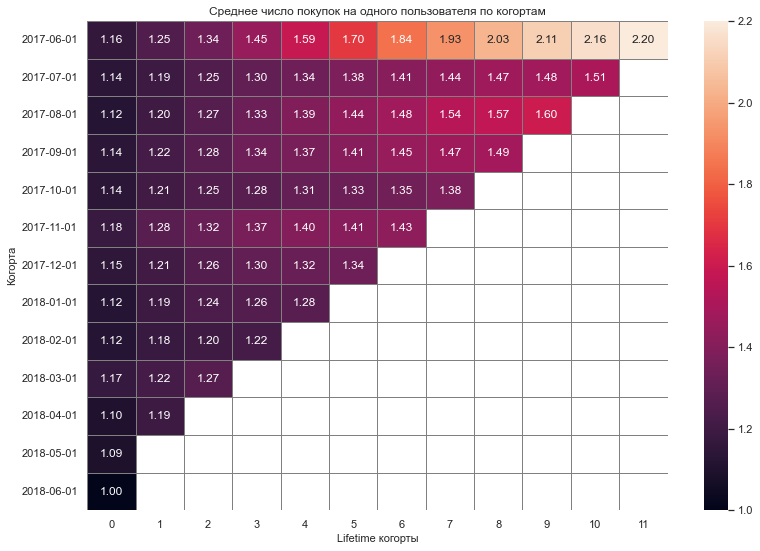

In [52]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(avg_orders_by_cohorts, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Среднее число покупок на одного пользователя по когортам')
plt.xlabel('Lifetime когорты', fontsize=11)
plt.ylabel('Когорта', fontsize=11)

avg_orders_by_cohorts_graph = plt.gcf()

Теперь рассчитаем среднее количество покупок на одного пользователя за 6 месяцев. 

In [53]:
round(avg_orders_by_cohorts[5].mean(), 2)

1.43

В среднем за шесть месяц один клиент покупает 1,43 билета.

#### Средний чек<a name="Средний-чек"></a>

Посчитаем средний чек.

In [54]:
orders['revenue'].mean()

4.999462127685547

Средний чек равен 5 у.е.

Посмотрим на распределение числа заказов по их суммам, чтобы понять, какие размеры покупок самые популярные.

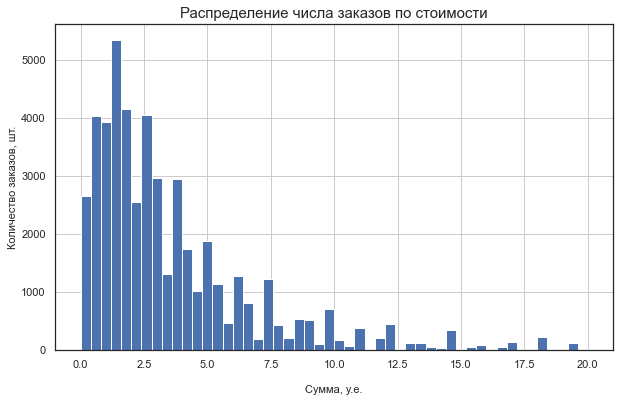

In [55]:
orders['revenue'].hist(bins=50, range=(0, 20), figsize=(10, 6))
plt.title('Распределение числа заказов по стоимости', fontsize=15)
plt.xlabel('Сумма, у.е.', fontsize=11, labelpad=15)
plt.ylabel('Количество заказов, шт.', fontsize=11)

orders_by_costs_graph = plt.gcf()

In [56]:
orders['revenue'].median()

2.5

Распределение не нормальное и скошено вправо. Медианная сумма заказа — 2,5 у.е.

Также посмотрим, как средний чек менялся по месяцам.

In [57]:
avg_check_by_month = orders.groupby('order_month')['revenue'].mean().reset_index()
avg_check_by_month.head()

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280


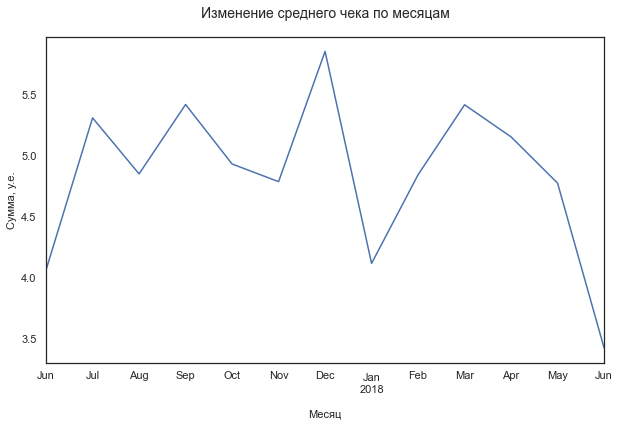

In [58]:
avg_check_by_month.plot(x='order_month', y='revenue', kind='line', legend=False, figsize=(10, 6))
plt.title('Изменение среднего чека по месяцам', fontsize=14, y=1.04)
plt.xlabel('Месяц', fontsize=11, labelpad=15)
plt.ylabel('Сумма, у.е.', fontsize=11)

avg_check_by_month_graph = plt.gcf()

Самый высокий средний чек в декабре, он почти равен 6 у.е. Возможно, пользователи заранее планируют досуг на Новогодние праздники, а также покупают билеты в качестве подарка. При этом в январе средний чек самый низкий: с декабрьского максимума он падает на треть до 4 у.е. Может быть, это связано с заранее сделанными заказами в декабре или с экономией из-за больших трат в предновогодний период.

В остальное время средний чек находится в районе 5 у.е. и не зависит от месяца.

#### Изменение во времени LTV на покупателя по когортам<a name="Изменение-во-времени-LTV-на-покупателя-по-когортам"></a>

Для наблюдения за тем, как меняется во времени LTV на покупателя по когортам, построим тепловую карту. Для этого нужна таблица с LTV по когортам и lifetime, а для нее:
1. найти дату первой покупки каждого покупателя,
2. вычислить число новых покупателей за каждую дату,
3. добавить дату первой покупки в таблицу с заказами,
4. сгруппировать таблицу и посчитать выручку.

В таблице `orders_report` уже есть первые три пункта, осталось добавить в нее прибыль и сгруппировать данные. Для расчета прибыли найдем выручку с каждой когорты по месяцам и умножим ее на маржинальность. Найдем выручку и сохраним ее в revenue_cohorts.

In [59]:
revenue_cohorts = (
    orders_new.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
revenue_cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.490234
1,2017-06-01,2017-07-01,981.820007
2,2017-06-01,2017-08-01,885.340027
3,2017-06-01,2017-09-01,1931.300049
4,2017-06-01,2017-10-01,2068.580078


Теперь объединим `revenue_cohorts` с `orders_report` и умножим выручку на маржинальность, чтобы найти прибыль.

In [60]:
orders_report = pd.merge(orders_report, revenue_cohorts, on=['first_order_month', 'order_month'])

margin_rate = 1
orders_report['gross_profit'] = orders_report['revenue'] * margin_rate

orders_report.head()

,first_order_month,n_buyers,order_month,n_orders,purchases_per_user,lifetime,revenue,gross_profit
0,2017-06-01,2023,2017-06-01,2354,1.163618,0,9557.490234,9557.490234
1,2017-06-01,2023,2017-07-01,177,0.087494,1,981.820007,981.820007
2,2017-06-01,2023,2017-08-01,174,0.086011,2,885.340027,885.340027
3,2017-06-01,2023,2017-09-01,226,0.111715,3,1931.300049,1931.300049
4,2017-06-01,2023,2017-10-01,292,0.144340,4,2068.580078,2068.580078


Теперь у нас есть все, чтобы найти LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде тепловой карты:

In [61]:
orders_report['ltv'] = orders_report['gross_profit'] / orders_report['n_buyers']

ltv_output = orders_report.pivot_table(index='first_order_month', columns='lifetime', values='ltv', aggfunc='mean')
ltv_output = ltv_output.cumsum(axis=1) 
ltv_output.index = ltv_output.index.to_series().apply(lambda x: x.date())

ltv_output.head()

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602052,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010219,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084036,8.231181,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762116,7.283045,11.258838,11.659396,12.306463,13.008071,13.251221,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888034,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN


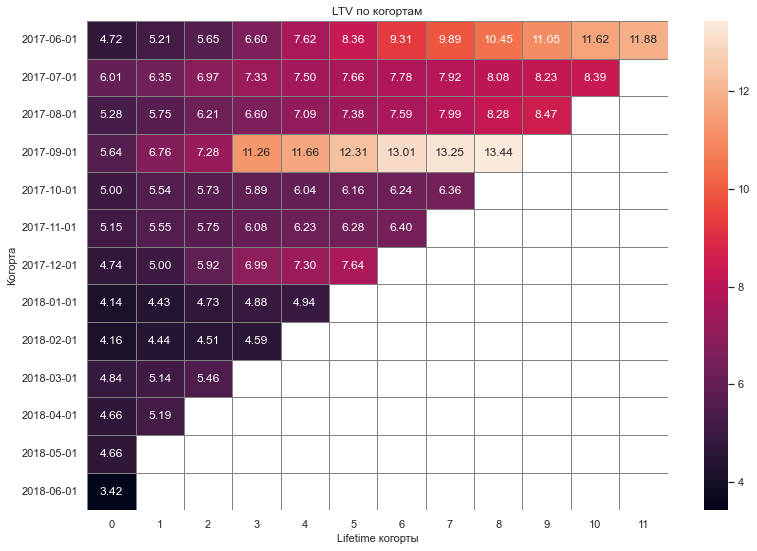

In [62]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(ltv_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('LTV по когортам')
plt.xlabel('Lifetime когорты', fontsize=11)
plt.ylabel('Когорта', fontsize=11)

ltv_graph = plt.gcf()

На тепловой карте выделяются июньская и сентрябрьская когорты, причем характер особенностей разный. Июньская когорта начинает показывать плавную опережающую динамика по сравнению с другими когортами, начиная с шестого месяца жизни. У сентябрьской когорты резкий скачок в третьем месяце. Возможно, ее участникам предложили выгодную акцию. Также интересно, что начало роста в обоих когортах пришлось на декабрь. Он может быть связан с удачным использованием новогодних распродаж.

Теперь рассчитаем средний LTV по когортам за шесть месяцев.

In [63]:
round(ltv_output[5].mean(), 2)

7.97

В среднем за полгода один покупатель приносит Яндекс.Афише почти восемь 8 у.е. валовой прибыли.

[К содержанию](#Содержание)

### Маркетинговые метрики<a name="Маркетинговые-метрики"></a>

#### Общая сумма расходов на маркетинг и распределение трат по источникам<a name="Общая-сумма-расходов-на-маркетинг-и-распределение-трат-по-источникам"></a>

Найдем общую сумму расходов на маркетинг. Для этого сложим все значения столбца `costs` в таблице `costs`.

In [64]:
total_marketing_cost = costs['costs'].sum()
total_marketing_cost

329131.6

Общие расходы на маркетинг составили почти 330 тысяч у.е.

Чтобы получить распределение трат по источникам, сгруппируем расходы по ним и посчитаем их сумму в каждой группе. Сохраним результат в новую таблицу `costs_per_source` и построим по ней распределение.

In [65]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source.rename(columns={'costs': 'costs_sum'},
                        inplace=True)
costs_per_source.head()

,source_id,costs_sum
0,1,20833.269531
1,2,42806.039062
2,3,141321.625000
3,4,61073.601562
4,5,51757.101562


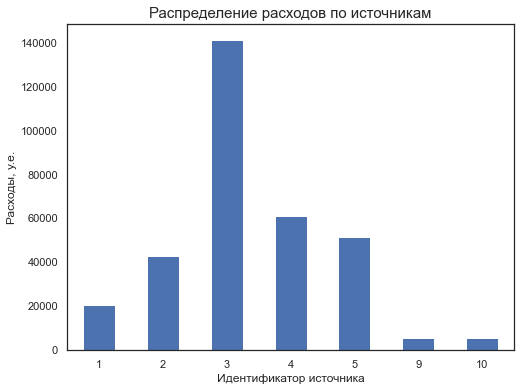

In [66]:
costs_per_source.plot(x='source_id', y='costs_sum', kind='bar',
                      figsize=(8, 6), legend=False)
plt.title('Распределение расходов по источникам', fontsize=15)
plt.xlabel('Идентификатор источника')
plt.xticks(rotation=0)
plt.ylabel('Расходы, у.е.')

costs_per_source_graph = plt.gcf()

Больше всего маркетологи потратили на третий источники трафика. Расходы на него почти в 2,5 раза больше, чем на четвертый и пятый источники. Они находятся на втором и третьем месте соответственно с примерно равными суммами.

#### Cредний CAC всего проекта и каждого источника трафика<a name="Cредний-CAC-всего-проекта-и-каждого-источника-трафика"></a>

Чтобы найти средний CAC одного покупателя для всего проекта, найдем суммарные затраты на маркетинг и разделим их на количество покупателей. 

Суммарные затраты мы уже считали, они хранятся в переменнной `total_marketing_cost`. Осталось найти число покупателей. Для этого посчитаем количество уникальных uid в таблице `orders`.

In [67]:
n_buyers = orders['uid'].nunique()

print('Суммарные затраты на маркетинг:', total_marketing_cost)
print('Число покупателей:', n_buyers)

Суммарные затраты на маркетинг: 329131.6
Число покупателей: 36523


Теперь у нас есть все, чтобы найти средний CAC на одного покупателя для всего проекта. Сделаем это.

In [68]:
average_cac_full_project = total_marketing_cost / n_buyers
average_cac_full_project

9.011625379897598

В среднем на привлечение одного покупателя маркетологи потратили чуть больше 9 у.е.

Теперь посчитаем средние CAC для каждого источника. Для этого нам нужны затраты на каждый источник и число покупателей, пришедших из них. Расходы по источникам у нас есть, они хранятся в `costs_per_source`.

Осталось найти число покупателей по источникам. Чтобы их посчитать, добавим в таблицу `orders` источник первого визита покупателя, а затем сгруппируем заказы по этому столбцу и посчитаем количество клиентов в группах.

Найдем источники первых визитов.

In [69]:
first_visit_source = visits.sort_values('start_ts').groupby('uid').first().reset_index()
first_visit_source = first_visit_source[['uid', 'source_id']]
first_visit_source.columns = ['uid', 'first_visit_source']
first_visit_source.head()

,uid,first_visit_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Объединим `orders` и `first_visit_source` по пользователю, а затем сгуппируем по источнику визита и посчитаем уникальных покупалетей в группе.

In [70]:
orders = orders.merge(first_visit_source, on='uid')
n_buyers_by_source = orders.groupby('first_visit_source')['uid'].nunique().reset_index()
n_buyers_by_source = n_buyers_by_source.rename(columns={'uid': 'n_buyers'})
n_buyers_by_source

,first_visit_source,n_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Добавим к получившийся таблице расходы по источникам. Разделим их на количество покупателей и получим искомый средний CAC по источникам.

In [71]:
n_buyers_and_costs_by_source = pd.merge(n_buyers_by_source, costs_per_source,
                                        left_on='first_visit_source', right_on='source_id')
n_buyers_and_costs_by_source['cac'] = (n_buyers_and_costs_by_source['costs_sum'] /
                                       n_buyers_and_costs_by_source['n_buyers'])

mean_cac_by_source = n_buyers_and_costs_by_source[['first_visit_source', 'cac']]
mean_cac_by_source.columns = ['first_visit_source', 'cac']
mean_cac_by_source

,first_visit_source,cac
0,1,7.186364
1,2,12.209367
2,3,13.493901
3,4,5.931779
4,5,7.467480
5,9,5.071223
6,10,4.381106


Для наглядности построим распределение.

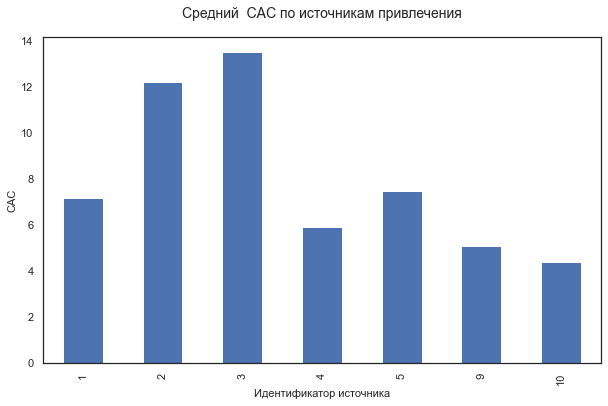

In [72]:
mean_cac_by_source.plot(x='first_visit_source', y='cac', kind='bar', legend=False, figsize=(10, 6))
plt.title('Средний  CAC по источникам привлечения', fontsize=14, y=1.04)
plt.xlabel('Идентификатор источника', fontsize=11)
plt.ylabel('CAC', fontsize=11)

mean_cac_by_source_graph = plt.gcf()

**Почему нет 6, 7 и 8 источников?**
* Из 6 источника нет ни одного покупателя, как и маркетинговых затрат.
* 7 источник принес одного покупателя, причем также без расходов на маркетинг. Получается, его CAC равен 0.
* У 8 источника нет ничего: ни посетителей, ни покупателей, ни маркетинговых трат.

#### ROMI по когортам в разрезе источников<a name="ROMI-по-когортам-в-разрезе-источников"></a>

ROMI равен отношению накопительного LTV к CAC, поэтому для его расчета по когортам в разрезе источников нам нужно эти метрики. CAC у нас есть, мы нашли их в предыдущем пункте. Рассчитаем LTV.

Сначала разделим пользователей по когортам. В качестве события возьмем первую покупку, а в качестве периода — месяц. Месяц первой покупки (и когорта) уже есть в таблице `orders_new`. Найдем lifetime когорт.

In [73]:
orders_new['lifetime'] = orders_new['order_month'] - orders_new['first_order_month']
orders_new['lifetime'] = orders_new['lifetime'] / np.timedelta64(1, 'M')
orders_new['lifetime'] = orders_new['lifetime'].round().astype('int')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0


Добавим в `orders_new` источник первого визита.

In [74]:
orders_new = pd.merge(orders_new, first_visit_source, on='uid')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime,first_visit_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0,3


Найдем размеры когорт: сгруппируем таблицу по источнику и когорте и посчитаем количество пользователей в группах.

In [75]:
source_cohorts_sizes = (orders_new
                        .groupby(['first_visit_source', 'first_order_month', 'lifetime'])
                        .agg({'uid':'nunique'})
                        .reset_index()
                       )
source_cohorts_sizes = source_cohorts_sizes.rename(columns={'uid': 'n_buyers'})
source_initial_cohorts = source_cohorts_sizes.query('lifetime==0')[['first_visit_source',
                                                                    'first_order_month', 'n_buyers']]

source_initial_cohorts.head()

,first_visit_source,first_order_month,n_buyers
0,1,2017-06-01,190
12,1,2017-07-01,160
23,1,2017-08-01,113
33,1,2017-09-01,227
42,1,2017-10-01,340


Добавим размеры когорт в `orders_new`.

In [76]:
orders_new = orders_new.merge(source_initial_cohorts, on=['first_visit_source', 'first_order_month'])
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime,first_visit_source,n_buyers
0,2017-06-01 00:10:00,17.000000,10329302124590727494,2017-06-01,2017-06-01,0,1,190
1,2017-06-01 09:22:00,1.220000,3644482766749211722,2017-06-01,2017-06-01,0,1,190
2,2017-06-02 12:44:00,0.850000,3644482766749211722,2017-06-01,2017-06-01,0,1,190
3,2017-06-02 15:08:00,12.830000,3644482766749211722,2017-06-01,2017-06-01,0,1,190
4,2017-06-04 13:06:00,17.110001,3644482766749211722,2017-06-01,2017-06-01,0,1,190


Найдем выручку для каждого времени жизни когорт и добавим ее в `orders_new`.

In [77]:
source_cohorts_revenue = (orders_new
                          .groupby(['first_visit_source', 'first_order_month', 'lifetime'])
                          .agg({'revenue': 'sum'})
                          .reset_index()
                         )
source_cohorts_revenue = source_cohorts_revenue.rename(columns={'revenue': 'revenue_sum'})
orders_new = orders_new.merge(source_cohorts_revenue, on=['first_visit_source', 'first_order_month', 'lifetime'])
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime,first_visit_source,n_buyers,revenue_sum
0,2017-06-01 00:10:00,17.000000,10329302124590727494,2017-06-01,2017-06-01,0,1,190,1378.699951
1,2017-06-01 09:22:00,1.220000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951
2,2017-06-02 12:44:00,0.850000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951
3,2017-06-02 15:08:00,12.830000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951
4,2017-06-04 13:06:00,17.110001,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951


LTV считают из валовой прибыли, а не из выручки. Найдем ее, умножив выручку на маржинальность, затем рассчитаем LTV.

In [78]:
orders_new['gross_profit'] = orders_new['revenue_sum'] * margin_rate
orders_new['ltv'] = orders_new['gross_profit'] / orders_new['n_buyers']
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime,first_visit_source,n_buyers,revenue_sum,gross_profit,ltv
0,2017-06-01 00:10:00,17.000000,10329302124590727494,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316
1,2017-06-01 09:22:00,1.220000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316
2,2017-06-02 12:44:00,0.850000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316
3,2017-06-02 15:08:00,12.830000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316
4,2017-06-04 13:06:00,17.110001,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316


Осталось добавить в таблицу CAC'и и разделить LTV на них.

In [79]:
orders_new = orders_new.merge(mean_cac_by_source, on='first_visit_source')
orders_new['romi'] = orders_new['ltv'] / orders_new['cac']
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,lifetime,first_visit_source,n_buyers,revenue_sum,gross_profit,ltv,cac,romi
0,2017-06-01 00:10:00,17.000000,10329302124590727494,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316,7.186364,1.009734
1,2017-06-01 09:22:00,1.220000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316,7.186364,1.009734
2,2017-06-02 12:44:00,0.850000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316,7.186364,1.009734
3,2017-06-02 15:08:00,12.830000,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316,7.186364,1.009734
4,2017-06-04 13:06:00,17.110001,3644482766749211722,2017-06-01,2017-06-01,0,1,190,1378.699951,1378.699951,7.256316,7.186364,1.009734


Теперь создадим цикл, в котором для каждого источника будем строить сводную таблицу с накопительным ROMI по времени жизни, а затем выводить тепловую карту по ней. Также будем считать среднюю когорту.

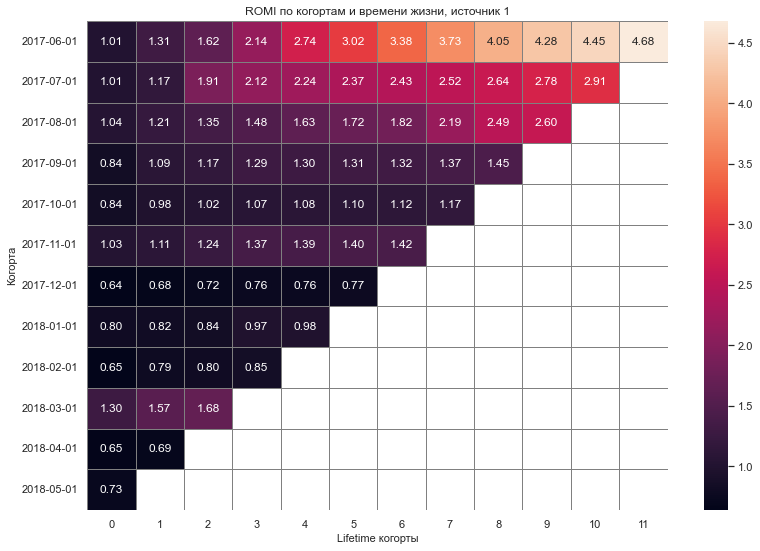

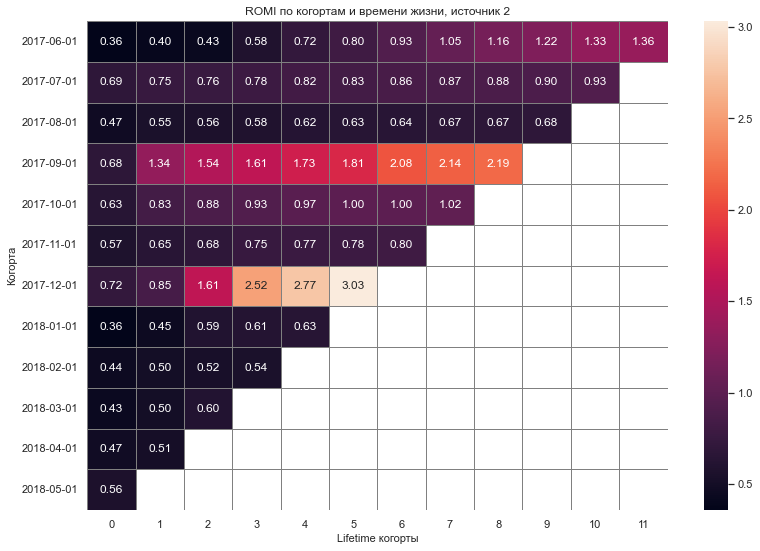

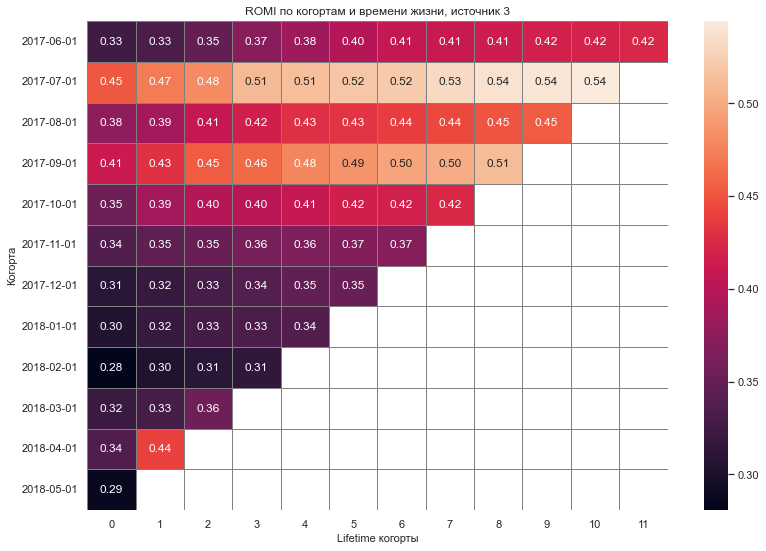

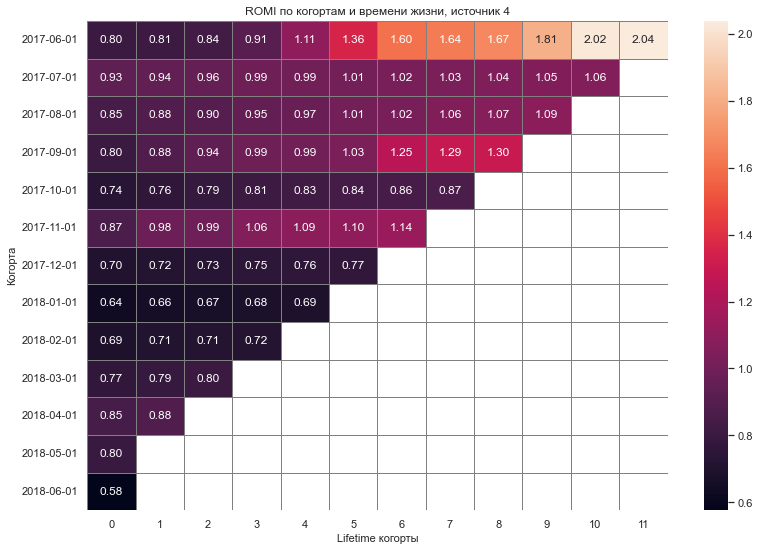

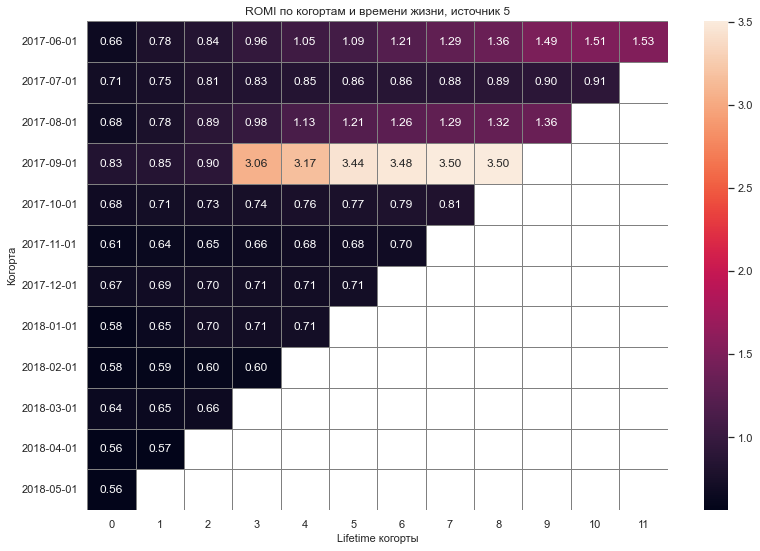

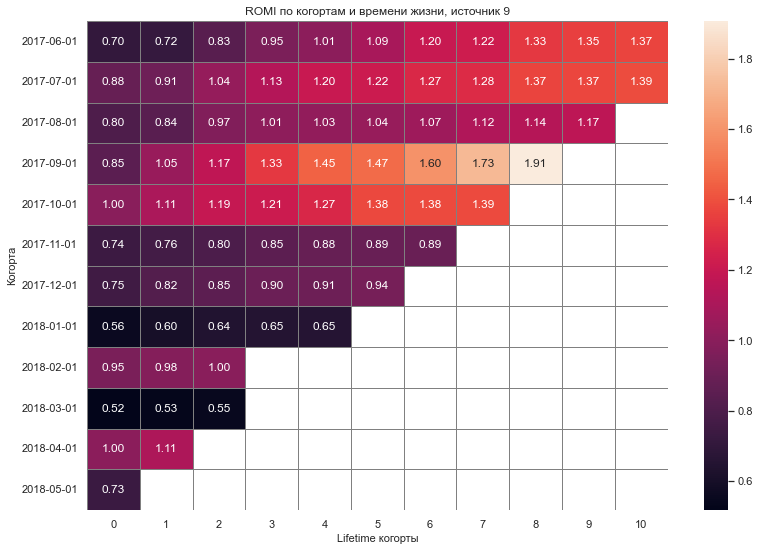

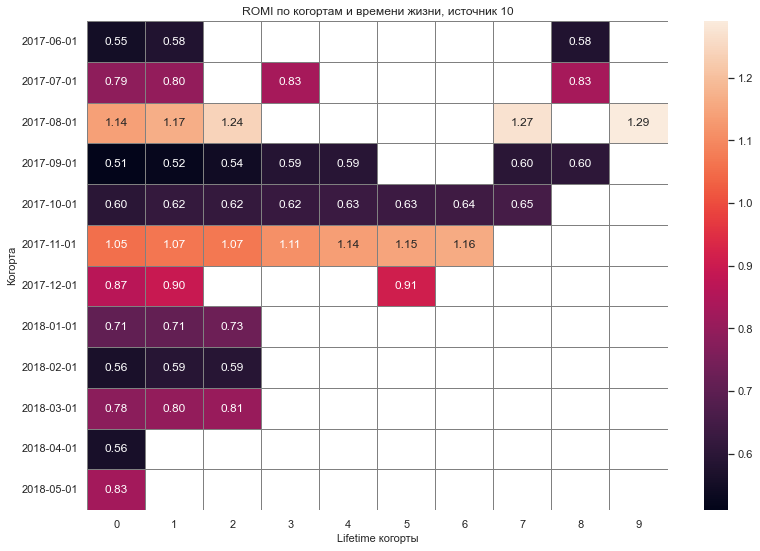

In [80]:
sources = list(orders_new['first_visit_source'].unique())
sources.sort()

for source in sources:
    orders_new_by_source = orders_new[orders_new['first_visit_source']==source]
    romi_output = (orders_new_by_source
                   .pivot_table(index='first_order_month', columns='lifetime',
                                values='romi', aggfunc='mean')
                  )
    romi_output = romi_output.cumsum(axis=1)
    romi_output.index = romi_output.index.to_series().apply(lambda x: x.date())
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(romi_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.title('ROMI по когортам и времени жизни, источник {}'.format(source))
    plt.xlabel('Lifetime когорты', fontsize=11)
    plt.ylabel('Когорта', fontsize=11)

Также посчитаем среднюю когорту для всех источников и объединим их в одну таблицу.

In [81]:
i = 0
for source in sources:
    orders_new_by_source = orders_new[orders_new['first_visit_source']==source]
    romi_output = (orders_new_by_source
                   .pivot_table(index='first_order_month', columns='lifetime',
                                values='romi', aggfunc='mean')
                  )
    romi_output = romi_output.cumsum(axis=1).mean(axis=0).reset_index()
    romi_output.columns = ['lifetime', 'source_{}_romi'.format(source)]
    
    if i == 0:
        romi_mean_cohorts = romi_output
        i += 1
    else:
        romi_mean_cohorts = romi_mean_cohorts.join(romi_output.set_index('lifetime'), how='left', on='lifetime')
        
romi_mean_cohorts

,lifetime,source_1_romi,source_2_romi,source_3_romi,source_4_romi,source_5_romi,source_9_romi,source_10_romi
0,0,0.878676,0.532533,0.341309,0.770610,0.647463,0.790423,0.745889
1,1,1.038220,0.665463,0.370093,0.818755,0.696766,0.857631,0.774688
2,2,1.234653,0.816947,0.376622,0.833640,0.747880,0.903565,0.799990
3,3,1.340225,0.990129,0.390065,0.872325,1.028575,1.006324,0.788487
4,4,1.514798,1.130509,0.408071,0.929241,1.131035,1.050033,0.787241
5,5,1.671441,1.268825,0.424647,1.016959,1.251486,1.146676,0.897110
6,6,1.915356,1.050936,0.441927,1.147502,1.382732,1.234533,0.899395
7,7,2.194927,1.151337,0.462313,1.176112,1.553852,1.348584,0.838681
8,8,2.657803,1.224670,0.478089,1.272349,1.770702,1.435950,0.671385
9,9,3.219621,0.932457,0.471131,1.318787,1.247852,1.298545,1.290616


[К содержанию](#Содержание)

## 3. Общий вывод<a name="3.-Общий-вывод"></a>

### Приоритетные источники трафика<a name="Приоритетные-источники-трафика"></a>

Перед определением приоритетных источников, вспомним их ROMI.

In [82]:
romi_mean_cohorts

,lifetime,source_1_romi,source_2_romi,source_3_romi,source_4_romi,source_5_romi,source_9_romi,source_10_romi
0,0,0.878676,0.532533,0.341309,0.770610,0.647463,0.790423,0.745889
1,1,1.038220,0.665463,0.370093,0.818755,0.696766,0.857631,0.774688
2,2,1.234653,0.816947,0.376622,0.833640,0.747880,0.903565,0.799990
3,3,1.340225,0.990129,0.390065,0.872325,1.028575,1.006324,0.788487
4,4,1.514798,1.130509,0.408071,0.929241,1.131035,1.050033,0.787241
5,5,1.671441,1.268825,0.424647,1.016959,1.251486,1.146676,0.897110
6,6,1.915356,1.050936,0.441927,1.147502,1.382732,1.234533,0.899395
7,7,2.194927,1.151337,0.462313,1.176112,1.553852,1.348584,0.838681
8,8,2.657803,1.224670,0.478089,1.272349,1.770702,1.435950,0.671385
9,9,3.219621,0.932457,0.471131,1.318787,1.247852,1.298545,1.290616


Маркетологам стоит делать упор на 1 источник трафика: он окупается быстрее всех (уже на второй месяц жизни), а также он самый прибыльный (через год ROMI почти достигает 5). Следующие по приоритету — 2, 4 и 9 источники. Они окупаются за 4–6 месяцев, а средний ROMI за год находится в районе 1,5.

Средняя когорта 5 источника тоже выглядит хорошо, но если посмотреть на ROMI по когортам и времени жизни, то можно увидеть, что значения сильно исказила сентябрьская когорта с аномальным скачком ROMI в декабре.

Также стоит сократить расходы на 3 источник. На него тратится больше всего средств, при этом клиенты, пришедшие из него, за год не окупаются даже наполовину. 

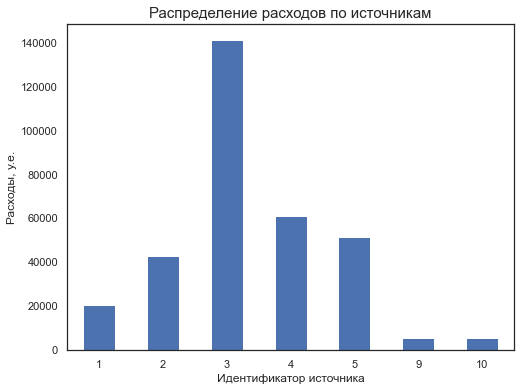

In [83]:
costs_per_source_graph

### Выводы после подсчета метрик<a name="Выводы-после-подсчета-метрик"></a>

Рассчитав MAU, мы узнали, что посещаемость Яндекс.Афиши с октября по март больше, чем в другие месяцы. Скорее всего, это связано с классической сезонностью ивент-индустрии.

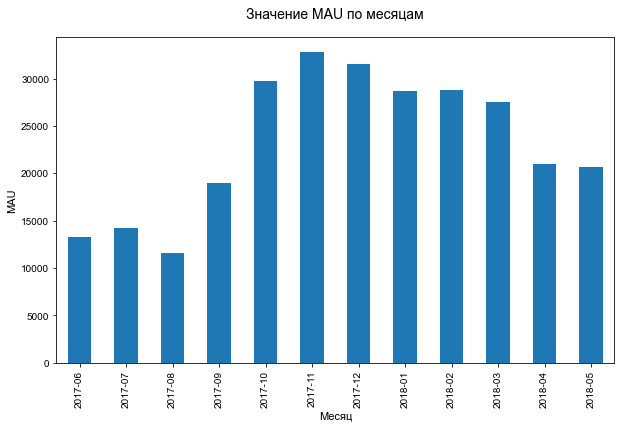

In [84]:
mau_graph

Также мы узнали, что пользователи не очень активно пользуются сайтом: в среднем пользователь заходит на сайт один раз в день и проводит на нем пять минут.

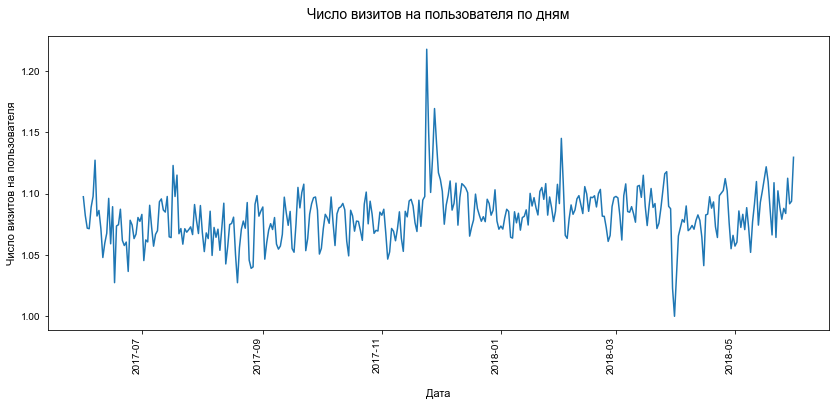

In [85]:
visits_per_user_graph

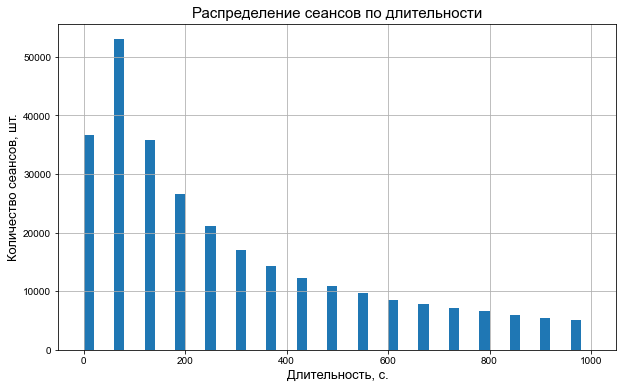

In [86]:
duration_graph

А еще на второй месяц «жизни» в среднем возвращается всего 6,5% пользователей. Вряд ли это говорит о недостатках платформы, просто большинство россиян [редко ходят](https://iom.anketolog.ru/2017/08/11/kak-rossiyane-provodyat-svoj-dosug) на культурные мероприятия. Например, концерты, театры и музеи чаще всего посещают один раз в год или реже.

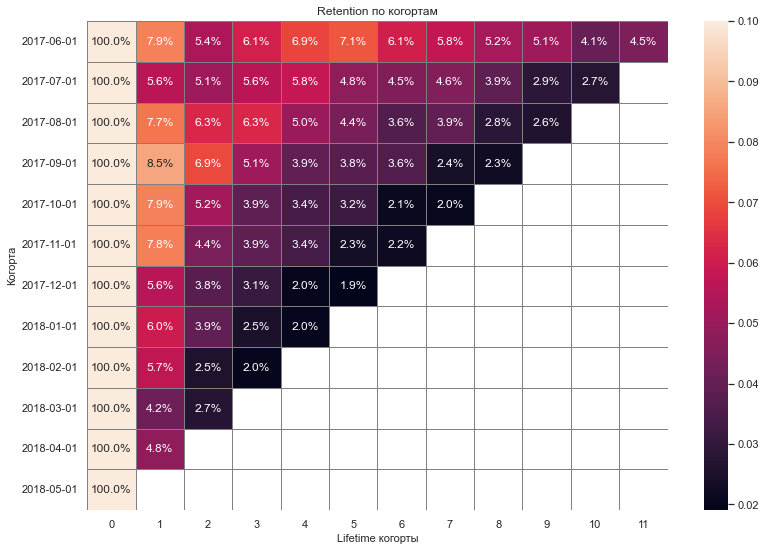

In [87]:
retention_by_cohorts_graph

### Итоги когортного анализа<a name="Итоги-когортного-анализа"></a>

Посмотрим на результат когортного анализа.

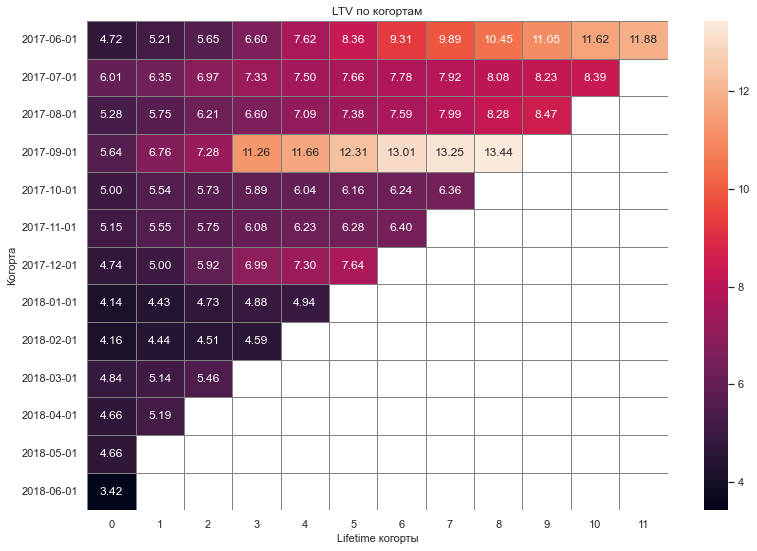

In [88]:
ltv_graph

Больше всего денег принесли сентябрьская и июньская когорты, они и являются самыми перспективными. Стоит определить, чем взаимодействие с ними отличается от работы с другими когортами, и перенести этот опыт на остальных пользователей.

[К содержанию](#Содержание)